<a href="https://colab.research.google.com/github/monarchythe/Plant-Disease-Prediction-Model/blob/main/Plant_Leaf_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Leaf Disease Detection

## Step 1: Mounting the Google Drive in Google Colab and loading the dataset.


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


Locating the folder where our data is stored to use it in our colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive/Projects/Plant-Leaf-Disease-Prediction".
!ls "/content/drive/MyDrive/Projects/Plant_Leaf_Disease_Prediction"

 Dataset   Model  'Streamlit App'


In [ ]:
!ls "/content/drive/MyDrive/Projects/Plant_Leaf_Disease_Prediction/Dataset"

'Corn_(maize)_Common_rust'   Model   Potato_Early_blight   Tomato_Bacterial_spot


## Step 2: Import the required libraires


Next we will import all the required libraries. As we are making a CNN model we will import all the required layers, activations, optimizers, etc.  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

In [ ]:
print(tf. __version__)

2.17.0


## Step 3:Visualizing the images and Resize images


Now we will observe some of the images that are their in our dataset. We will plot 12 images here using the matplotlib library.

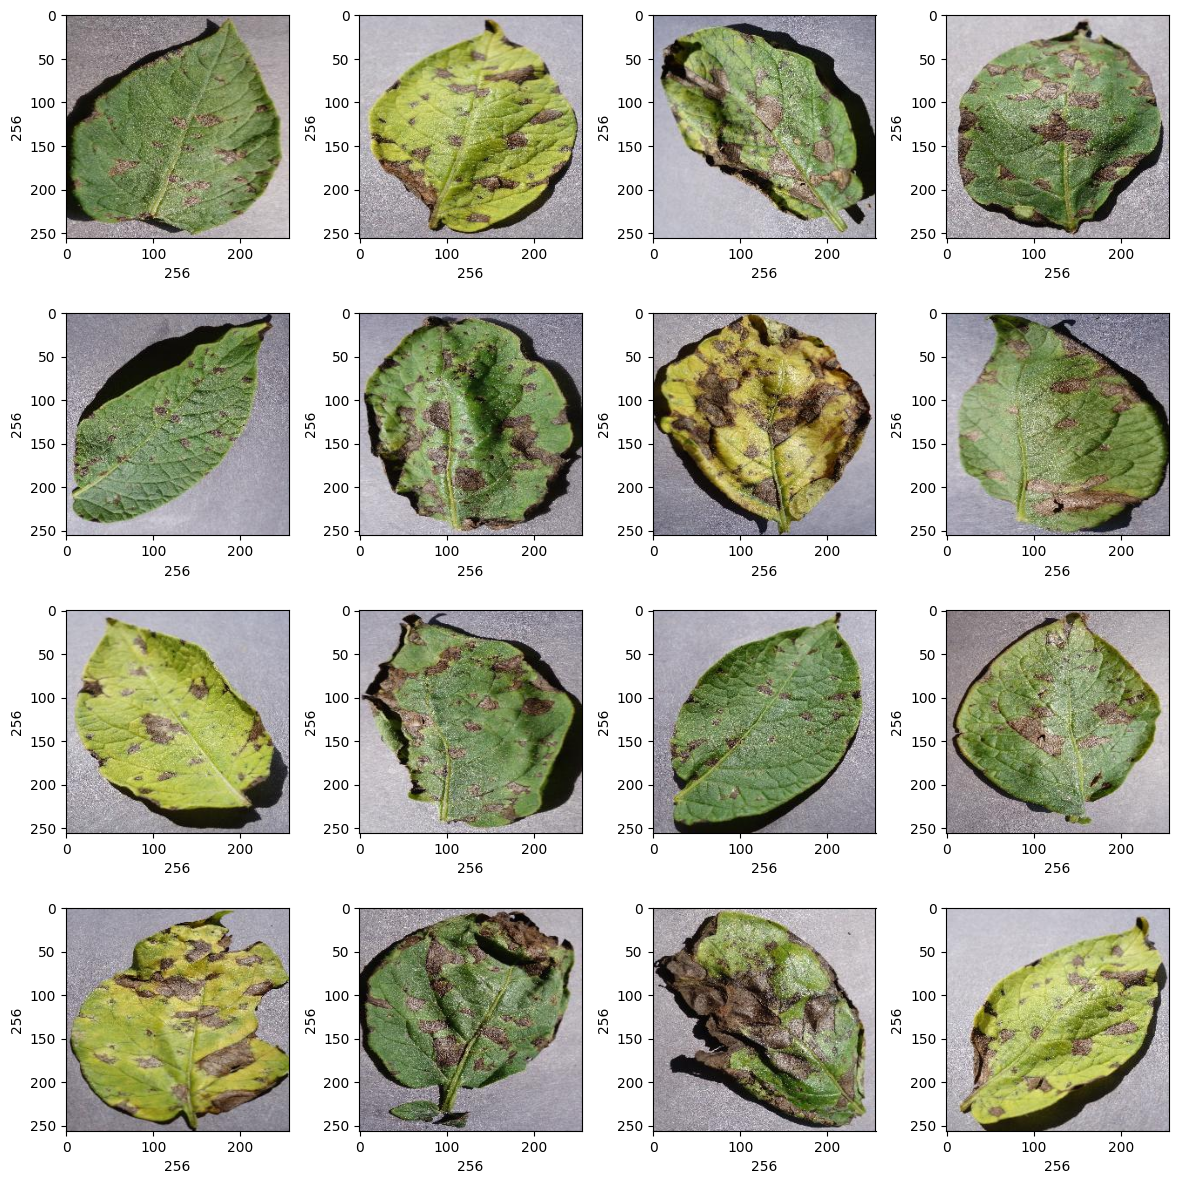

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/Projects/Plant_Leaf_Disease_Prediction/Dataset/Potato_Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

## Step 4: Convert the images into a NumPy array and normalize them.


After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Now we will convert all the images into numpy array.

In [ ]:
dir = "/content/drive/MyDrive/Projects/Plant_Leaf_Disease_Prediction/Dataset"
image_list, label_list = [], []
all_labels = ['Tomato-Bacterial_spot', 'Potato-Early_blight', 'Corn-Common_rust']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in ['Tomato_Bacterial_spot', 'Potato_Early_blight', 'Corn_(maize)_Common_rust']:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

## Step 5: Visualize the class count and Check for class imbalance


We will also observe the number of images under different classes to see if the dataset is balanced or not

Next we will observe the shape of the image.

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()
label_counts[:5]

,count
0,
0,300
1,300
2,300


In [ ]:
image_list[0].shape
image_list[:1]

[array([[[104., 103., 113.],
         [111., 110., 120.],
         [126., 125., 135.],
         ...,
         [143., 143., 149.],
         [153., 153., 159.],
         [163., 163., 169.]],
 
        [[125., 124., 134.],
         [119., 118., 128.],
         [120., 119., 129.],
         ...,
         [146., 146., 152.],
         [144., 144., 150.],
         [143., 143., 149.]],
 
        [[120., 119., 129.],
         [111., 110., 120.],
         [107., 106., 116.],
         ...,
         [147., 147., 153.],
         [145., 145., 151.],
         [142., 142., 148.]],
 
        ...,
 
        [[125., 123., 129.],
         [127., 125., 131.],
         [136., 134., 140.],
         ...,
         [163., 159., 164.],
         [155., 151., 156.],
         [147., 143., 148.]],
 
        [[123., 121., 127.],
         [127., 125., 131.],
         [126., 124., 130.],
         ...,
         [170., 166., 171.],
         [163., 159., 164.],
         [155., 151., 156.]],
 
        [[121., 119., 125.],
 

Checking the total number of the images which is the length of the labels list.

In [ ]:
label_list = np.array(label_list)
label_list.shape

(900,)

## Step 6: Splitting the dataset into train, validate and test sets


Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.

In [ ]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

## Step 7: Performing one-hot encoding on target variable

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Step 8: Creating the model architecture, compile the model and then fit it using the training data



```
# This is formatted as code
```

Creating a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         225,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,347 (903.70 KB)

 Trainable params: 231,347 (903.70 KB)

 Non-trainable params: 0 (0.00 B)

While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Next we will split the training dataset into validation and training data.

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 10)

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 10 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy but here we can see that the model has already raeched a very high accuracy so we don't need to run it for more. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [ ]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4986 - loss: 0.9305 - val_accuracy: 0.6597 - val_loss: 0.7100
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6816 - loss: 0.6634 - val_accuracy: 0.6597 - val_loss: 0.5700
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6724 - loss: 0.5345 - val_accuracy: 0.6597 - val_loss: 0.5170
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6651 - loss: 0.4998 - val_accuracy: 0.6597 - val_loss: 0.4960
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6678 - loss: 0.4690 - val_accuracy: 0.6597 - val_loss: 0.4822
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6752 - loss: 0.4419 - val_accuracy: 0.6597 - val_loss: 0.4709
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6514 - loss: 0.4462 - val_accuracy: 0.6597 - val_loss: 0.4597
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6883 - loss: 0.4111 - val_accuracy: 0.6597 - val_loss: 0

Saving the model using different techniques.

In [ ]:
model.save("/content/drive/MyDrive/Projects/Plant_Leaf_Disease_Prediction/Dataset/Model/plant_disease_model.h5")

## Step 9: Plot the accuracy and loss against each epoch

Next we will plot the accuracy of the model for the trainig history.

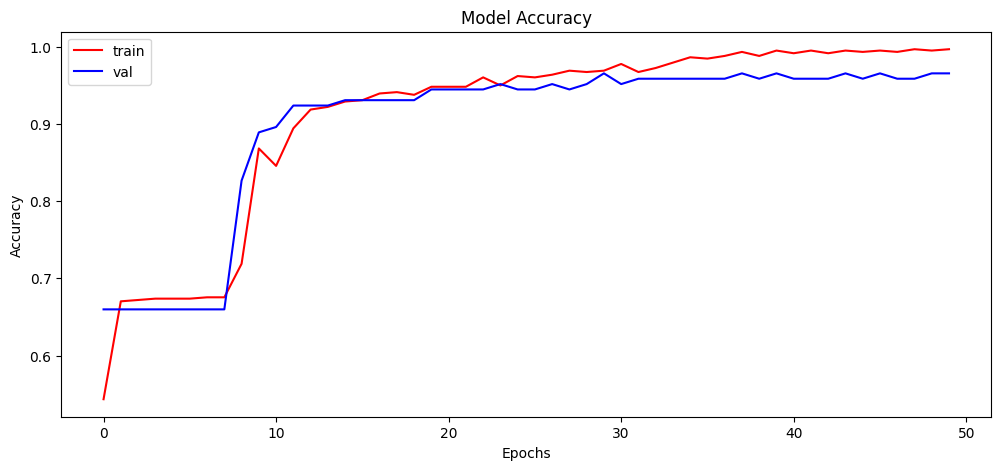

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Evaluating the model to know the accuracy of the model.


In [ ]:
print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9884 - loss: 0.0380
Test Accuracy: 97.77777791023254


## Step 10: Make predictions on testing data

Next we will use our model to predict predicting the testing dataset label.

In [ ]:
y_pred = model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


## Step 11: Visualizing the original and predicted labels for the test images

Printing out the original and the predicted label.

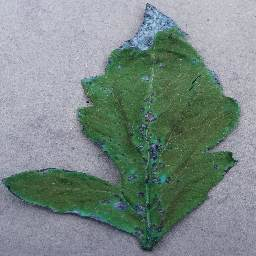

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[11])
img

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
print("Original Label: ",all_labels[np.argmax(y_test[11])])
print("Predicted Label: ",all_labels[np.argmax(y_pred[4])])
print (y_pred[2])

Original Label:  Tomato-Bacterial_spot
Predicted Label:  Tomato-Bacterial_spot
[3.7155863e-07 8.9845114e-04 9.9910110e-01]


In [ ]:
for i in range(50):
  print (all_labels[np.argmax(y_test[i])], "-", all_labels[np.argmax(y_pred[i])])

Potato-Early_blight - Potato-Early_blight
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Potato-Early_blight - Potato-Early_blight
Potato-Early_blight - Potato-Early_blight
Potato-Early_blight - Potato-Early_blight
Potato-Early_blight - Potato-Early_blight
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Corn-Common_rust - Corn-Common_rust
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Corn-Common_rust - Corn-Common_rust
Corn-Common_rust - Corn-Common_rust
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Tomato-Bacterial_spot - Tomato-Bacterial_spot
Corn-Common_rust - Corn-Common_rust
Potato

## Conclusion

We started the implementation of project with loading the dataset into google colab from google drive and visualizing the images. Normalizing is an important step when working with any type of dataset. After that we created a CNN Model which is further used for predicting the plant leaf diseases using the image supplied to model.
This model is highly beneficial as it can be used by different agricultural firms and farmers to increase their yield and stop wastage of crops due to disease.

## Step 12:
